## 1) Get the data: SDSS spectra and class labels
<img src="https://www.sdss.org/wp-content/uploads/2014/11/SDSS_telescope_new.jpg" width=500 />
The Sloan Digital Sky Survey (SDSS) is a full-sky survey that has been running at Apache Point Observatory since 2000. Up-to-date information can be found here: https://www.sdss.org/.
In this tutorial we will use spectra taken with spectroscopic plates as shown below. See http://voyages.sdss.org/preflight/sdss-plates/ for more information on these. 
<img src="https://www.sdss.org/wp-content/uploads/2019/11/apogeen-plugging.png" width=300 />

In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import os
import csv
import tensorflow as tf

data_path = 'data_spectra/'

#data=flux=3522, n_objects=7000 ?

# list of flux values, labels, and wavelength values
data = np.load(data_path + "data.npy")
labels = np.load(data_path + "labels.npy")
wavelengths = np.load(data_path + "wavelengths.npy")
print(np.shape(data))
print(np.shape(wavelengths))

# list number of objects
numbers = range(np.shape(data)[0])
print(numbers)
# datapoints per spectrum
wave_shape = np.shape(data)[1]
print('wave_shape',wave_shape)

print(wavelengths[0])
print(wavelengths[-1])
n_wave = np.shape(wavelengths)[0]
print(n_wave)
R = wavelengths[-1]/((wavelengths[-1] - wavelengths[0])/n_wave)
print(R)

(7000, 3522)
(3522,)
range(0, 7000)
wave_shape 3522
4000.3674
8999.12
3522
6340.561635782988


## 2) Plot our spectra

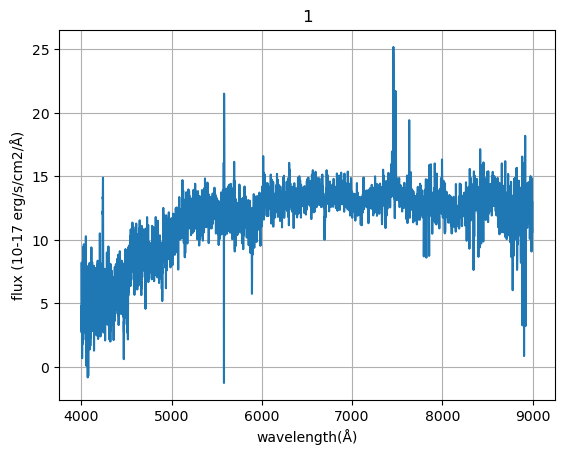

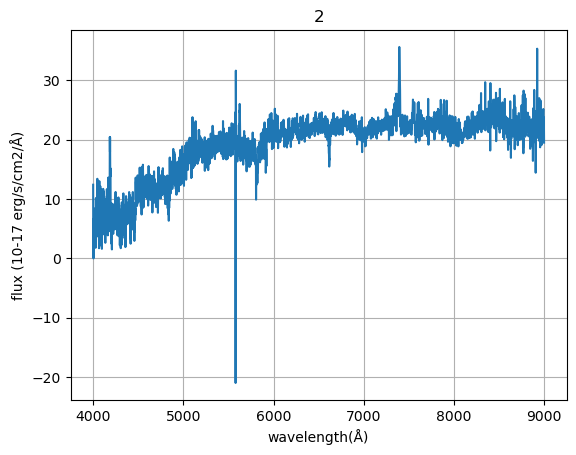

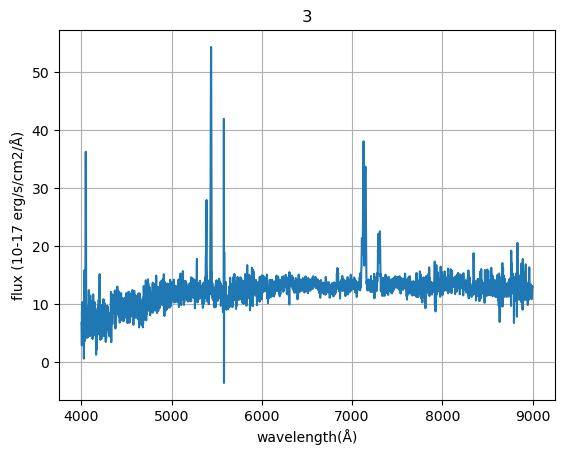

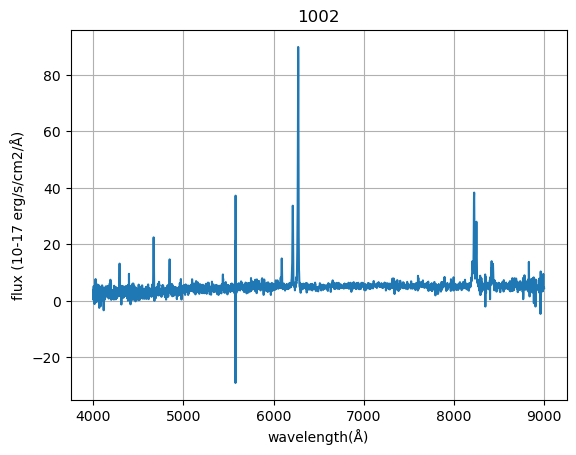

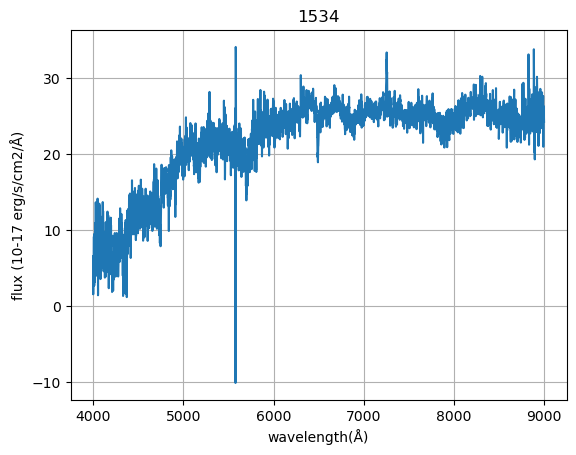

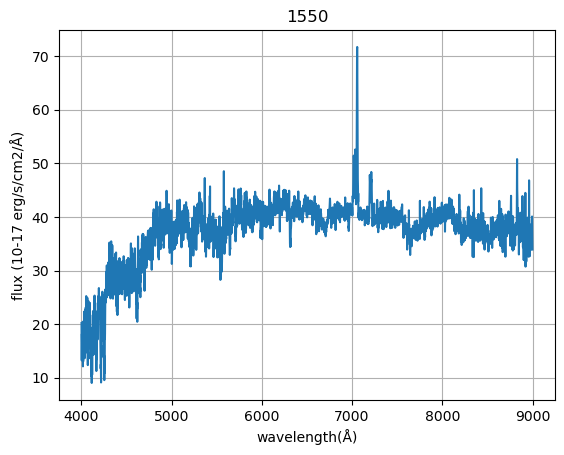

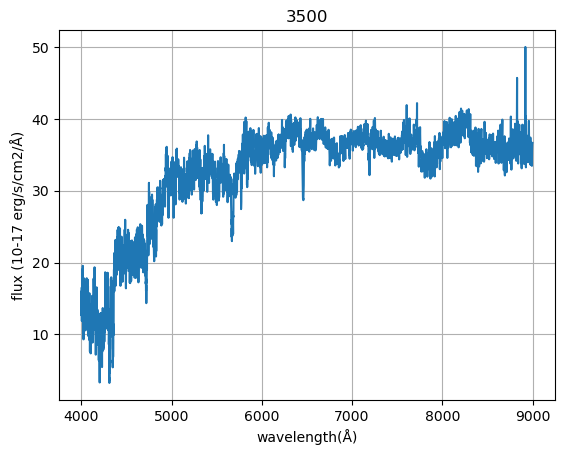

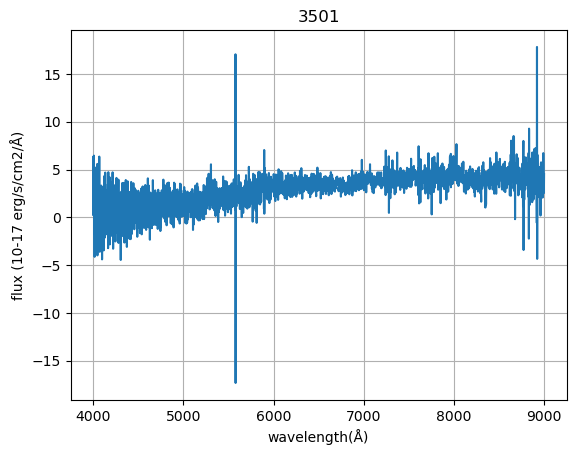

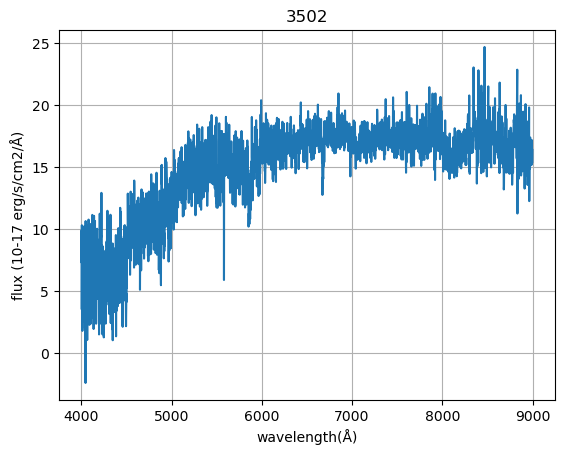

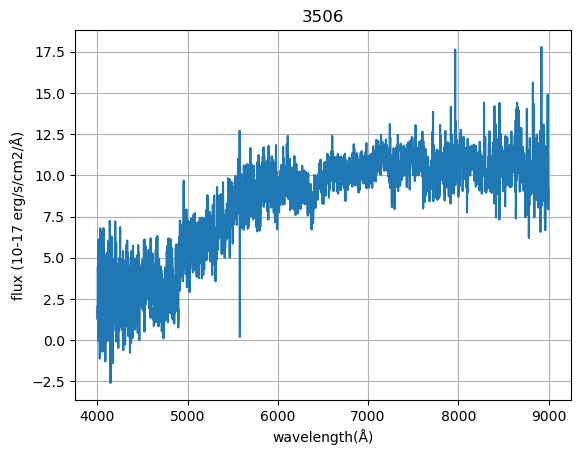

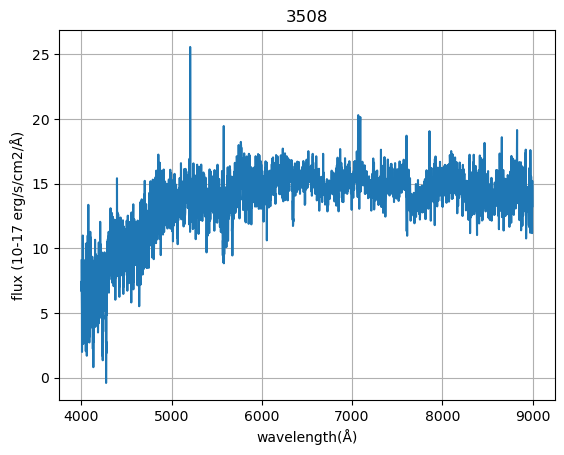

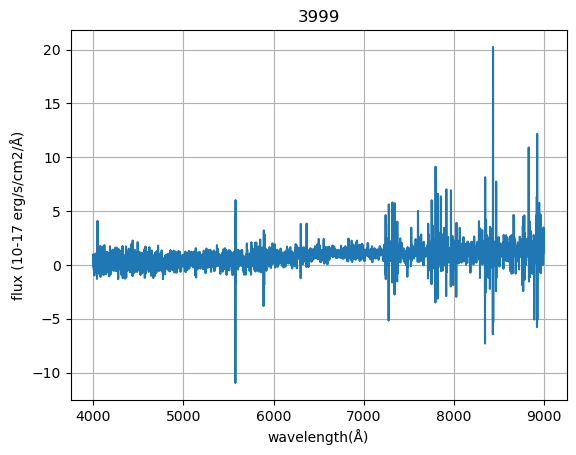

In [2]:
for i in [1, 2, 3, 1002, 1534, 1550, 3500,3501,3502,3506,3508,3999]: # some example spectra
    plt.plot(wavelengths, data[i]) 
    plt.xlabel('wavelength(Å)') 
    plt.ylabel('flux (10-17 erg/s/cm2/Å)') 
    # 10^7 erg = 1 Joule (energy)
    plt.grid(True)
    plt.title(str(i))
    plt.show()

## 3) Create training and test data set

In [3]:
import random

# shuffle the data
z = list(zip(data, labels, numbers)) 
random.shuffle(z)
data_shuffled, labels_shuffled, numbers_shuffled = zip(*z)

print(np.array(data_shuffled).shape)
print(np.array(labels_shuffled).shape)

(7000, 3522)
(7000,)


In [4]:
# test and training split
percent_split = 0.9
split_index = int(len(data_shuffled)*percent_split)

# Flux
data_training = np.asarray(data_shuffled[:split_index])
data_test = np.asarray(data_shuffled[split_index:])

# Labels
labels_training = np.asarray(labels_shuffled[:split_index])
labels_test = np.asarray(labels_shuffled[split_index:])

# Number
numbers_training = numbers_shuffled[:split_index]
numbers_test = numbers_shuffled[split_index:]

In [5]:
# reshape training and test set
input_shape = (wave_shape,1)
print(input_shape)

data_training_r = np.reshape(data_training, newshape=(len(data_training), input_shape[0], input_shape[1]))
data_test_r  = np.reshape(data_test, newshape=(len(data_test), input_shape[0], input_shape[1]))

print(data_training_r.shape)
print(data_test_r.shape)
print(labels_training.shape)

(3522, 1)
(6300, 3522, 1)
(700, 3522, 1)
(6300,)


In [6]:
# further set-up of training and test data, optional normalization
do_normalize = True

if do_normalize:
    # L2-normalization (i.e. the sum of squared of elements is set equal to one)
    x_train = tf.keras.utils.normalize(data_training_r, axis=1)
    x_test = tf.keras.utils.normalize(data_test_r, axis=1)
else:
    x_train = data_training_r
    x_test = data_test_r

y_train = labels_training
y_test = labels_test

## 4) Create the network

In [8]:
#import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, Dropout, InputLayer, GlobalAveragePooling1D
from keras.metrics import Accuracy
#from tensorflow import keras
from keras import layers

print(input_shape)

(3522, 1)


In [9]:
# create network model
# example - try out what happens if you alter different hyperparameters

no_filter = 32
kernel_size = 20
strides = 10
dropout = 0.35
pooling = 3

# our model or architecture
model = tf.keras.Sequential([
    # add convolutional layer
    Conv1D(filters=no_filter, kernel_size=kernel_size, strides=strides, activation='relu', input_shape=input_shape), # stride
    # max-pooling against overfitting
    MaxPooling1D(pooling), 
    # dropout against overfitting
    Dropout(dropout), 
    # add convolutional layer
    Conv1D(filters=2*no_filter, kernel_size=2*kernel_size, strides=strides, activation='relu'),
    # max-pooling against overfitting
    MaxPooling1D(pooling),
    # dropout against overfitting
    Dropout(dropout),
    # flatten to feed into dense layers
    Flatten(),
    # Adds a densely-connected layer
    Dense(units=128, activation='relu'), # units = dimensionality of output
    # dropout again
    Dropout(dropout),
    # Add another dense layer, now a softmax (probability of different classes as the output)
    Dense(units=4, activation='softmax')
])

/Users/caroline/anaconda3/envs/spectral_classifier/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# compile the network model, choose optimiser, loss-function etc.
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', # labels provided as integers (not one-hot)
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 351, 32)        │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 117, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 117, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 8, 64)          │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,684 (389.39 KB)

 Trainable params: 99,684 (389.39 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# train the network model
history = model.fit(x_train, y_train,
                    epochs=200, validation_split=0.1,
                    shuffle=True, batch_size=200,
                    verbose=1)

# we can also save and/or load a model
#model = tf.keras.models.load_model('spectral_classifier_v2.h5')
#model.save('spectral_classifier_v2.h5')

Epoch 1/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3652 - loss: 1.2755 - val_accuracy: 0.3873 - val_loss: 1.0613
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4024 - loss: 1.0707 - val_accuracy: 0.6095 - val_loss: 0.8867
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5635 - loss: 0.8541 - val_accuracy: 0.6254 - val_loss: 0.6987
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6174 - loss: 0.7141 - val_accuracy: 0.6603 - val_loss: 0.6524
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6437 - loss: 0.6760 - val_accuracy: 0.6873 - val_loss: 0.6331
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6469 - loss: 0.6638 - val_accuracy: 0.6873 - val_loss: 0.6120
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6562 - loss: 0.6663 - val_accuracy: 0.7016 - val_loss: 0.6036
Epoch 8/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6773 - loss: 0.6368 - val_accuracy: 0.

In [12]:
# save the model
model.save('spectral_network_classifier_CNN1.h5')

In [13]:
model = tf.keras.models.load_model('spectral_network_classifier_CNN1.h5')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 351, 32)        │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 117, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 117, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 8, 64)          │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,686 (389.40 KB)

 Trainable params: 99,684 (389.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

## 5) Monitor the training

In [20]:
for key in history.history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


In [21]:
def plot_accuracy(name, ylim=[0,1.01]):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(ylim[0], ylim[1])
    plt.legend(['training', 'validation'], loc='upper left')
    plt.savefig(name)
    plt.show()

In [22]:
def plot_loss(name, ylim=[0,2]):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(ylim[0],ylim[1])
    plt.legend(['training', 'validation'], loc='upper left')
    plt.savefig(name)
    plt.show()


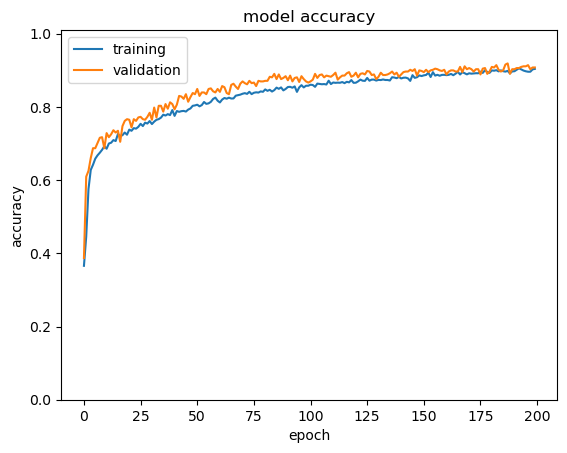

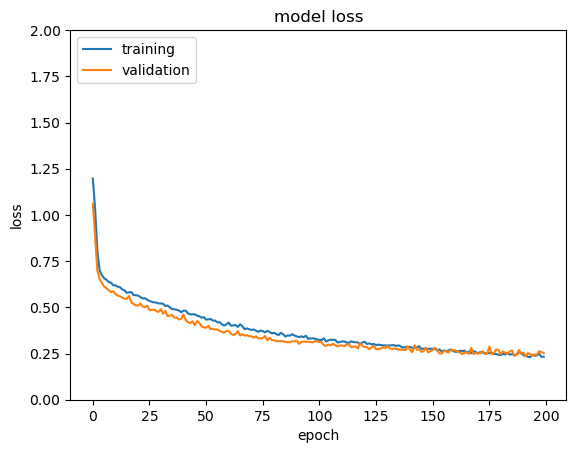

In [23]:
plot_accuracy("accuracy_graph_goldbig.png")
plot_loss("loss_graph_goldbig.png")

## Test the network model - predictive performance

In [24]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [25]:
# predict on the test data
predictions = model.predict(x=x_test)
rounded_predictions = np.argmax(predictions, axis=-1)

class_names = ['AGN','galaxy','QSO','star']

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


### Confusion Matrix

In [26]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[202  23   3]
 [ 38 214   2]
 [  7   0 211]]


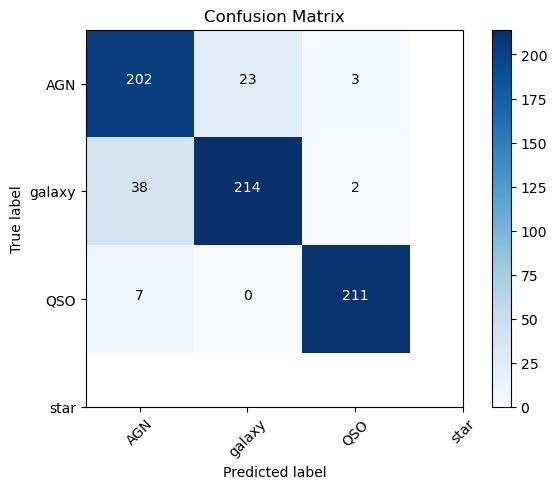

In [27]:
cm = confusion_matrix(y_true=y_test, y_pred=rounded_predictions)
plot_confusion_matrix(cm=cm, classes=class_names, title='Confusion Matrix')

## Confusion matrix (percentage)

Confusion matrix, without normalization
[[88.6  10.09  1.32]
 [14.96 84.25  0.79]
 [ 3.21  0.   96.79]]


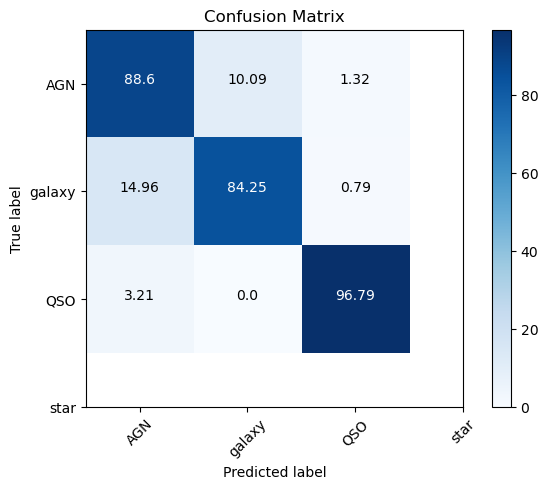

In [28]:
cm = confusion_matrix(y_true=y_test, y_pred=rounded_predictions)
cm_shape = np.shape(cm)

cm_percentages = np.zeros(shape=cm_shape)
for i in range(cm_shape[0]):
    total_objects = sum(cm[i])
    
    for t in range(cm_shape[0]):
        number_guessed = cm[i][t]
        cm_percentages[i][t] = round(number_guessed/total_objects*100,2)

plot_confusion_matrix(cm=cm_percentages, classes=class_names, title='Confusion Matrix')

## Class-wise accuracy

In [29]:
class_accuaracy = []

for i in range(cm_shape[0]):
    total_objects = sum(cm[i])
    correct_guesses = cm[i][i]
    class_accuaracy.append(correct_guesses/total_objects)
    
print("Accuracy for class")
for i in range(cm_shape[0]):
    print(class_names[i], "\t:", round(class_accuaracy[i],4)*100, "%")

Accuracy for class
AGN 	: 88.6 %
galaxy 	: 84.25 %
QSO 	: 96.78999999999999 %


## Having a look at false predictions

**Label 0 = AGN** \
**Label 1 = galaxy** \
**Label 2 = QSO** \
**Label 3 = star**

In [30]:
predictions = model.predict(x=x_test)
rounded_predictions = np.argmax(predictions, axis=-1)

wrong_predictions = []

for i in range(len(rounded_predictions)):
    if rounded_predictions[i] != y_test[i]:
        wrong_predictions.append(numbers_test[i])      

wrong_predictions.sort()
        
print(len(rounded_predictions), "right")
print(len(wrong_predictions), "false")
print(str(((len(rounded_predictions)-len(wrong_predictions))/len(rounded_predictions))*100) + "% correctly classified")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
700 right
73 false
89.57142857142857% correctly classified


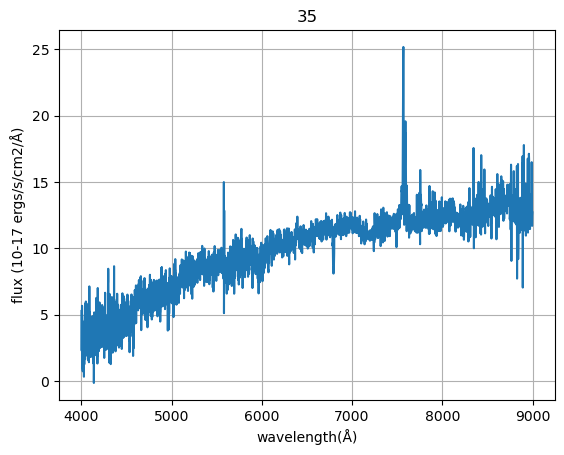

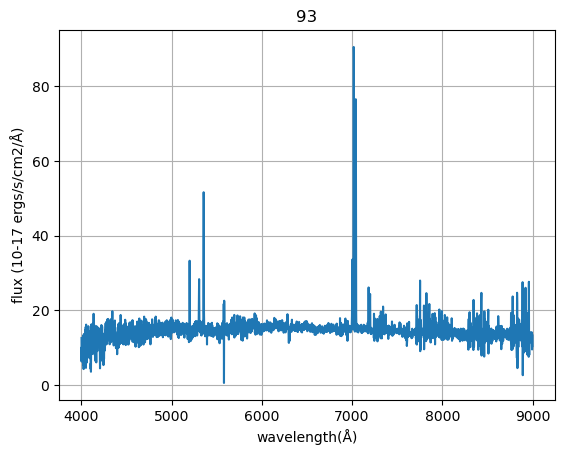

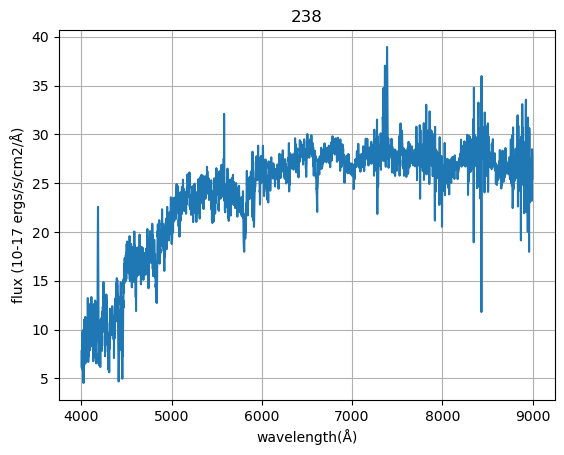

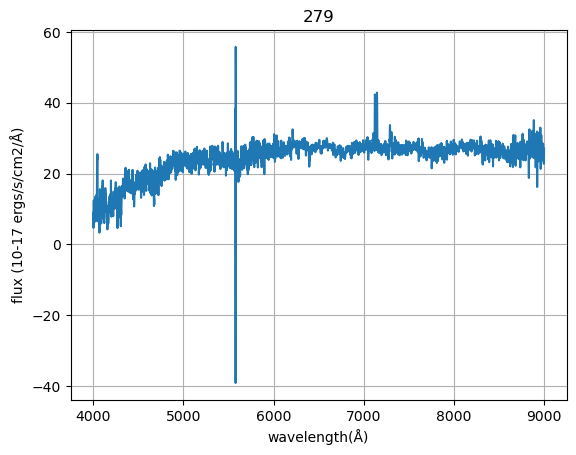

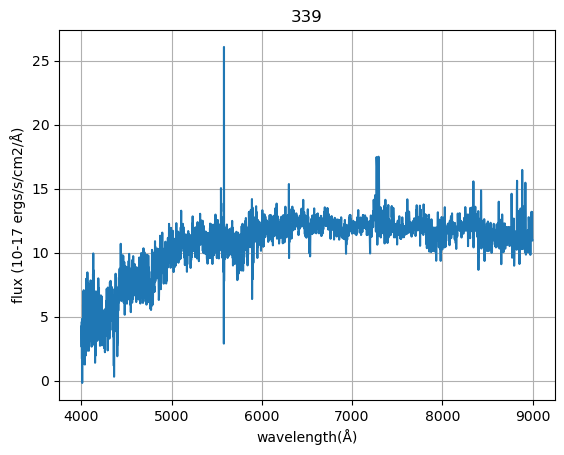

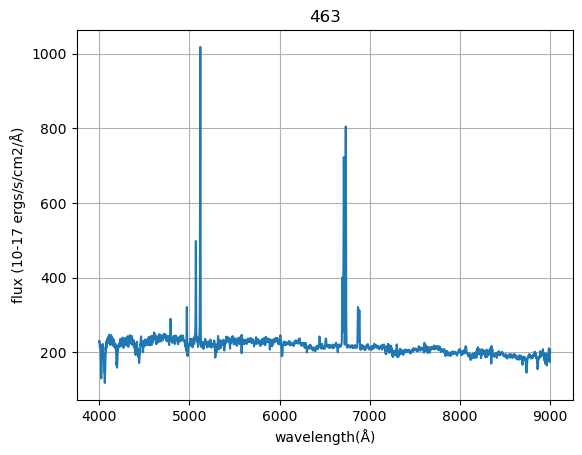

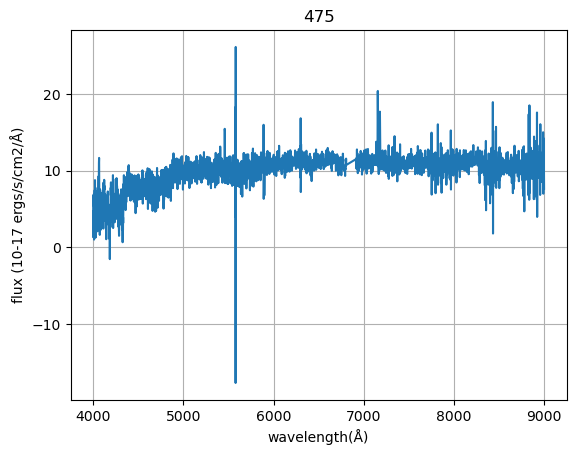

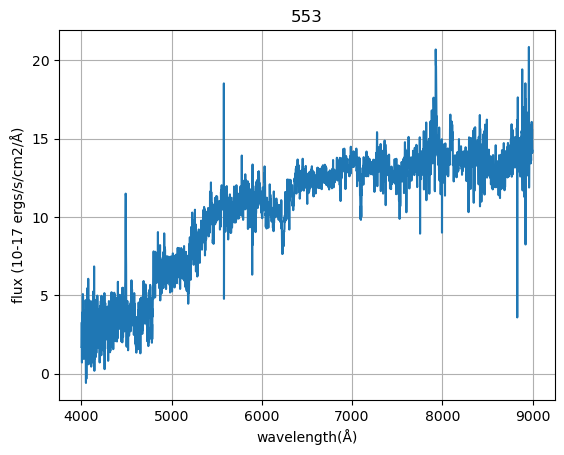

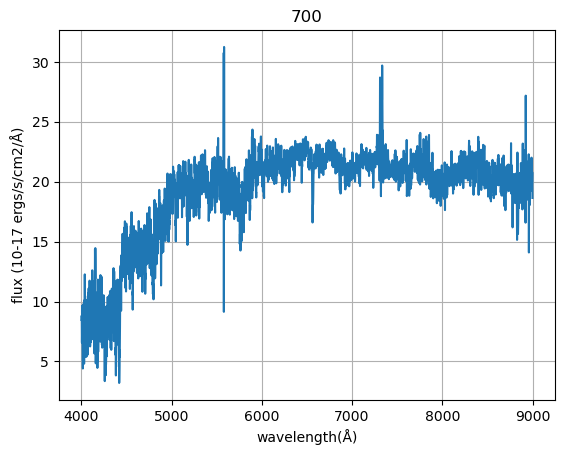

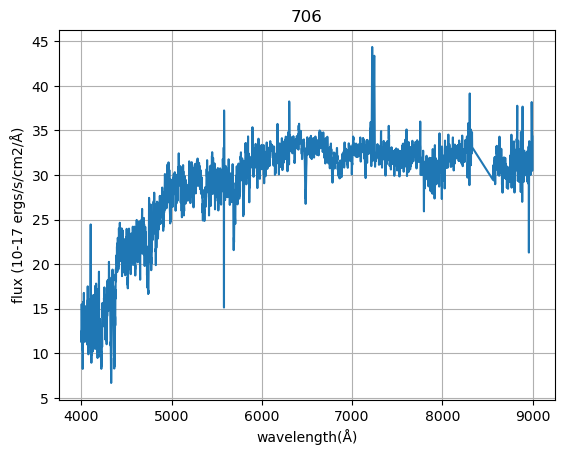

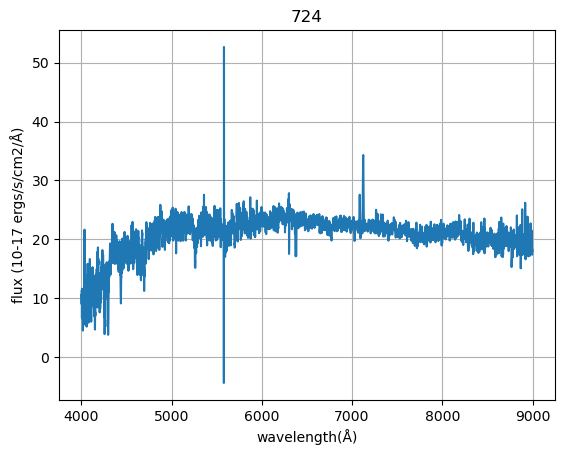

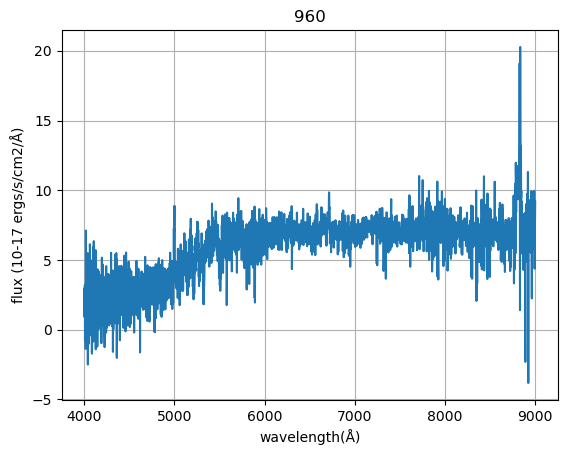

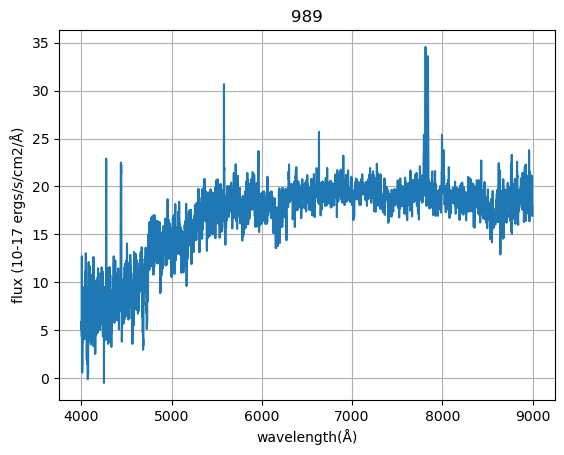

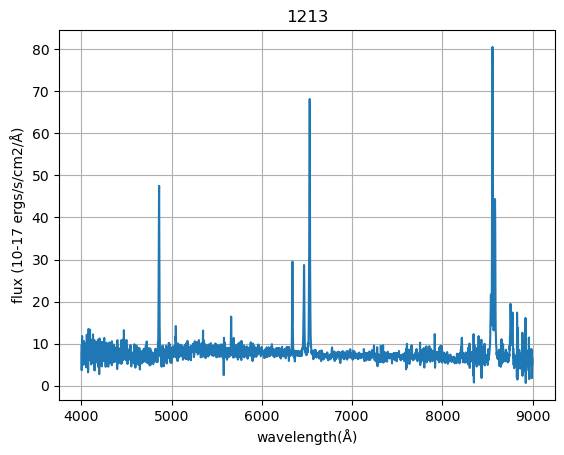

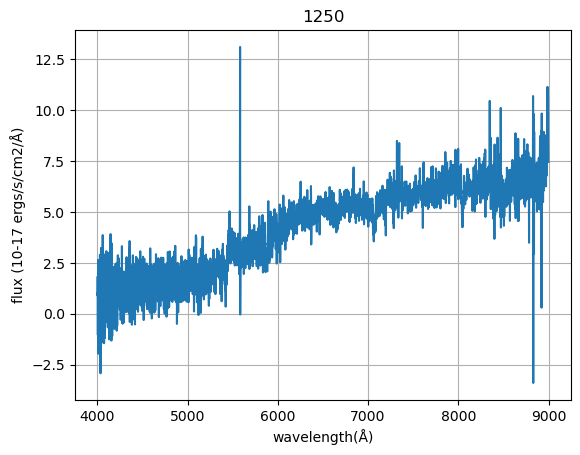

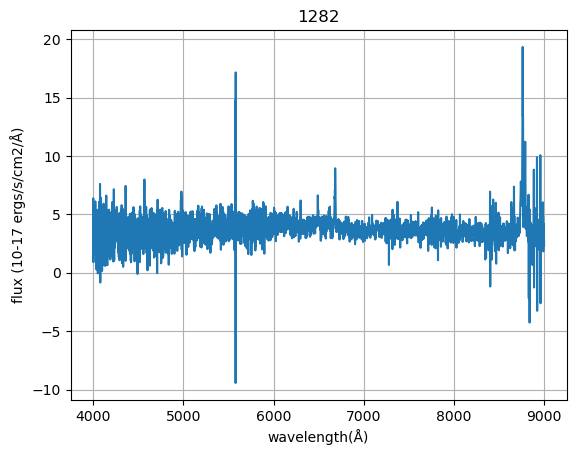

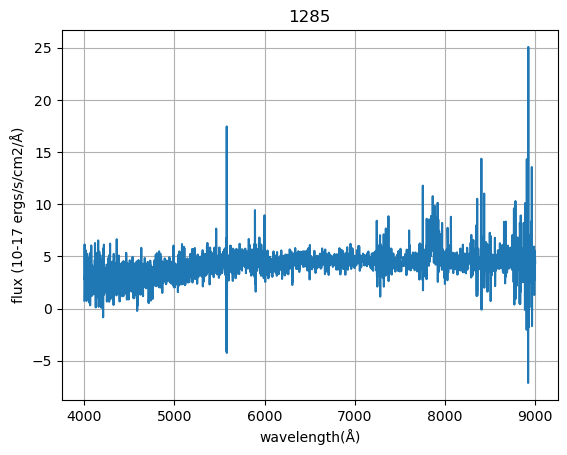

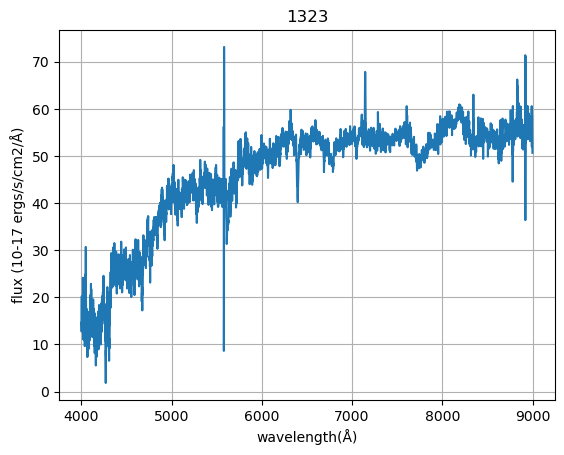

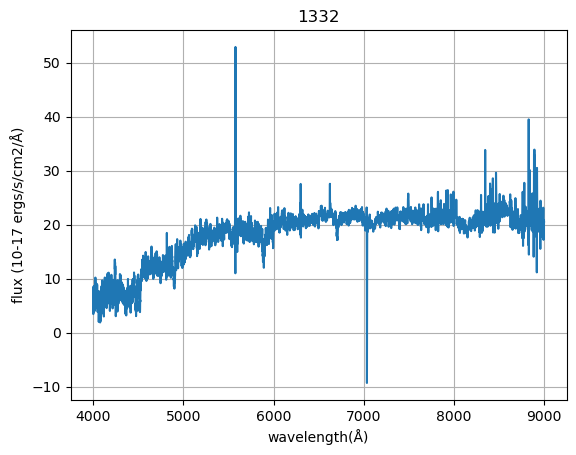

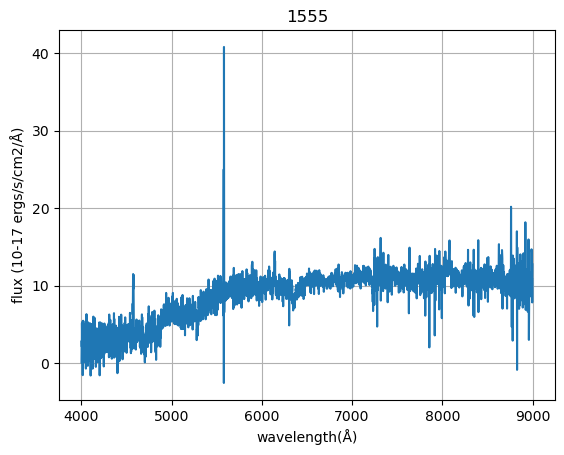

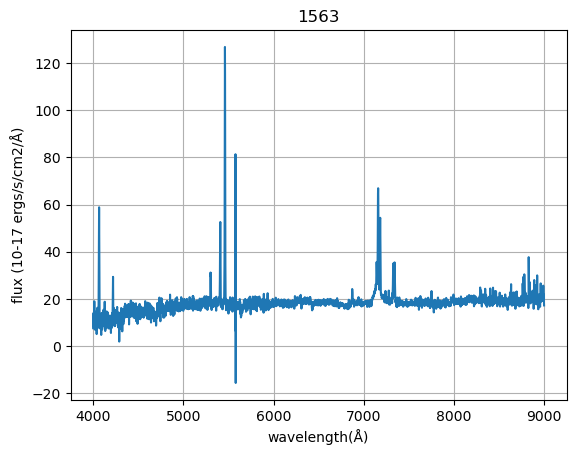

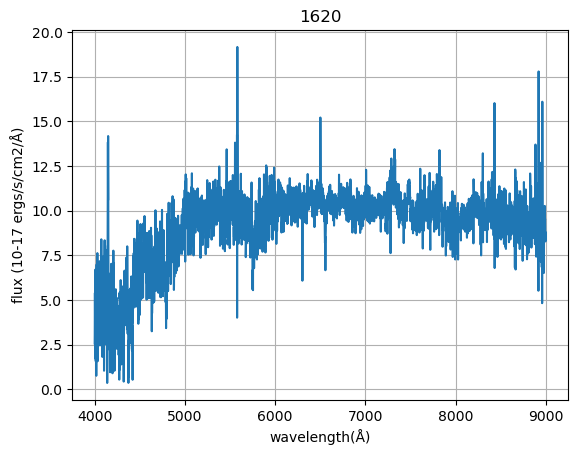

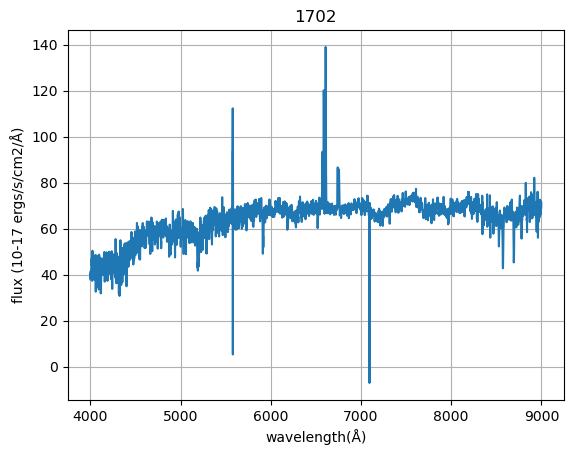

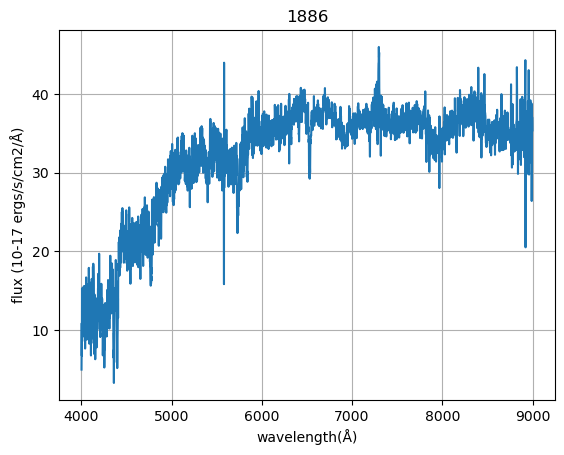

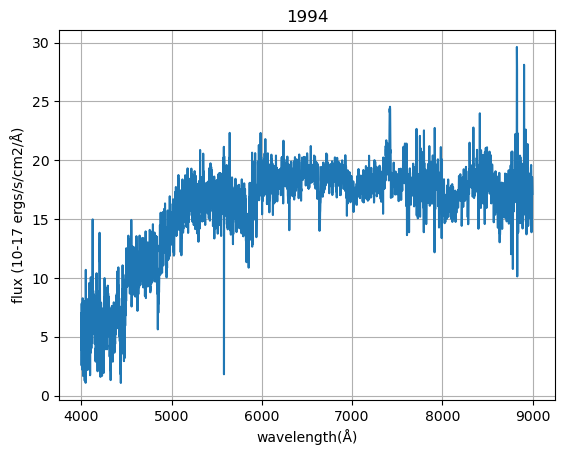

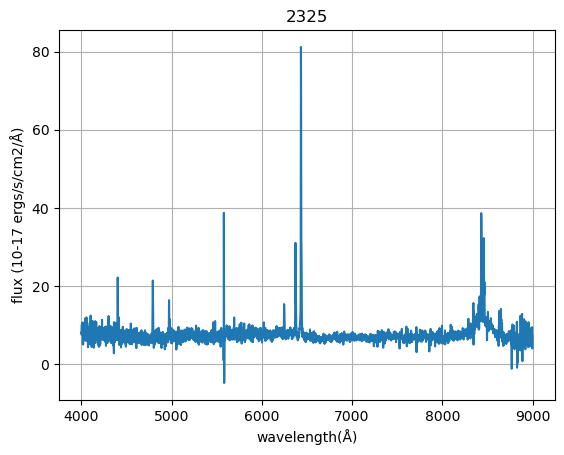

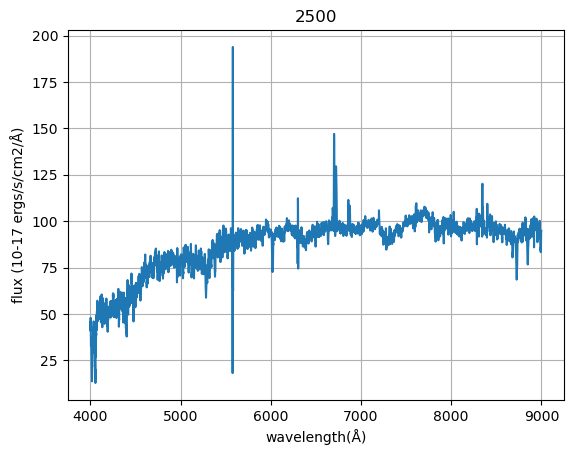

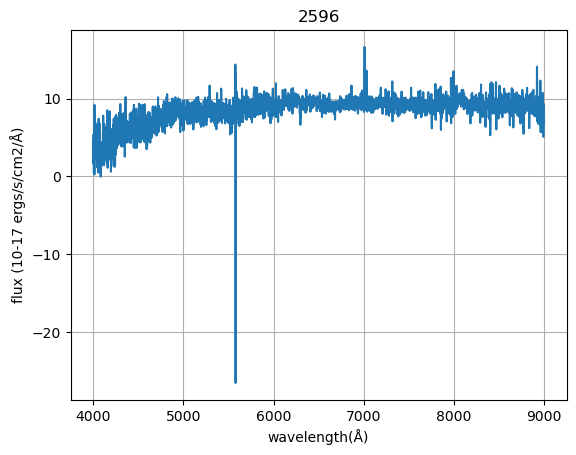

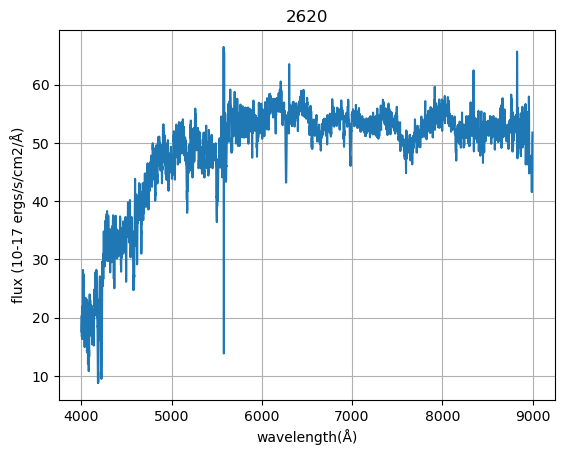

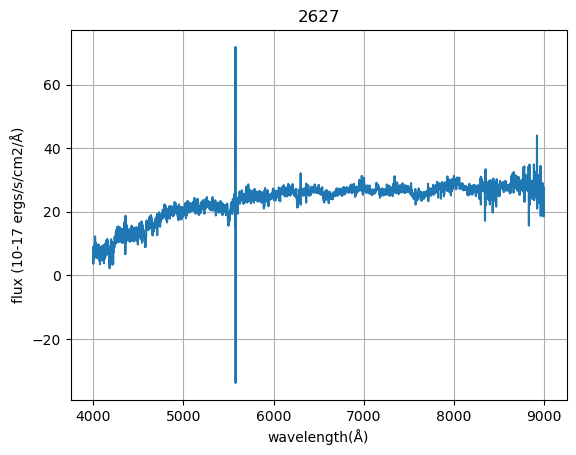

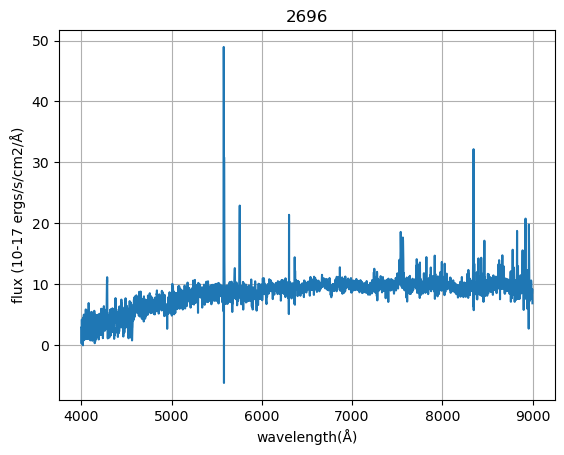

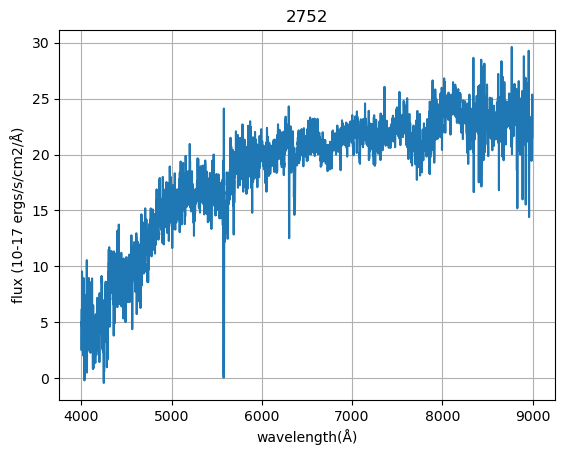

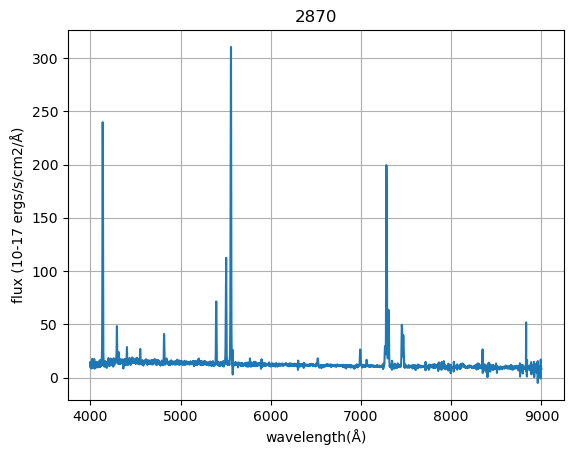

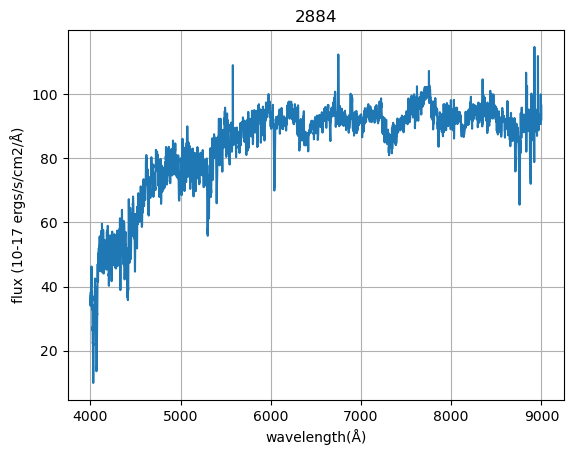

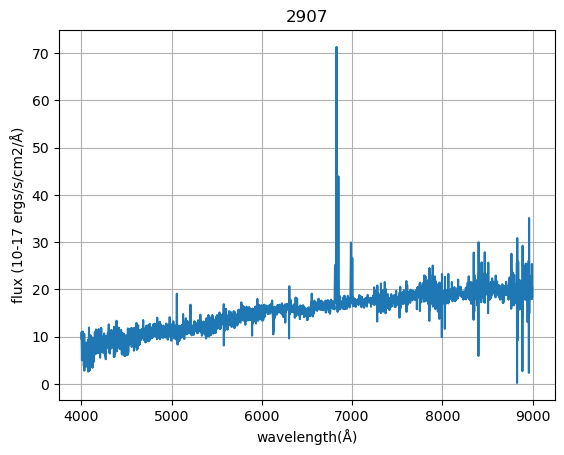

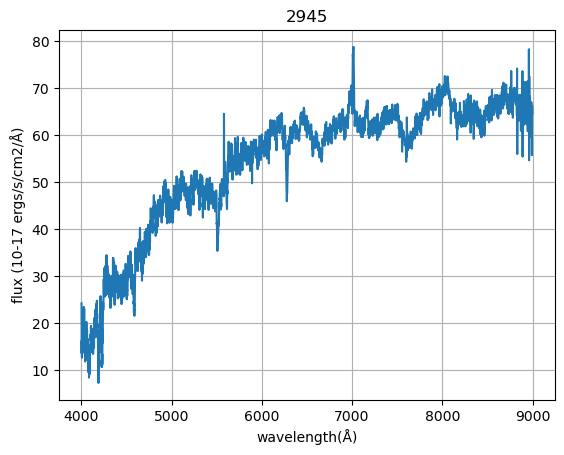

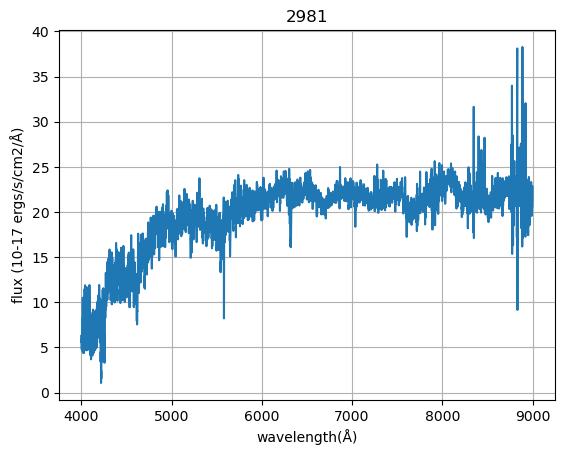

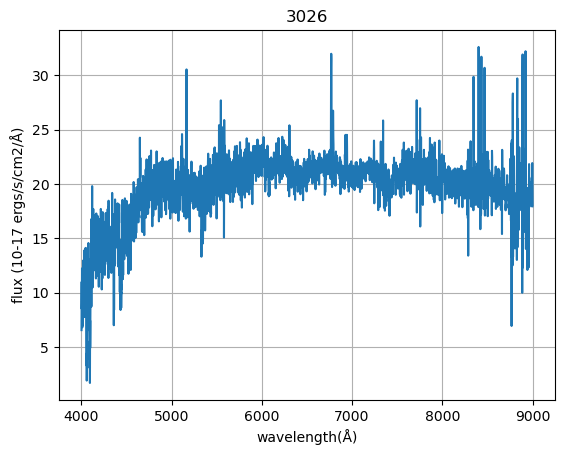

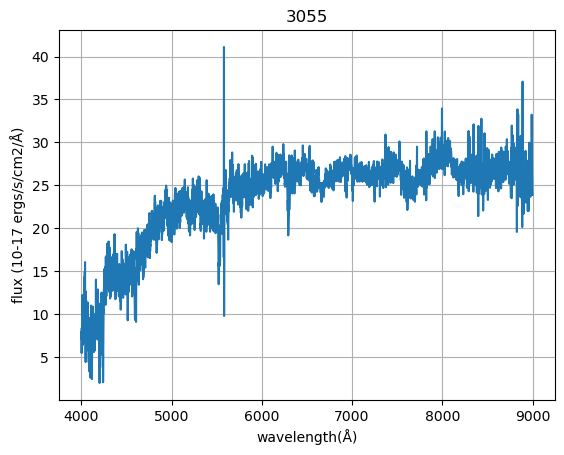

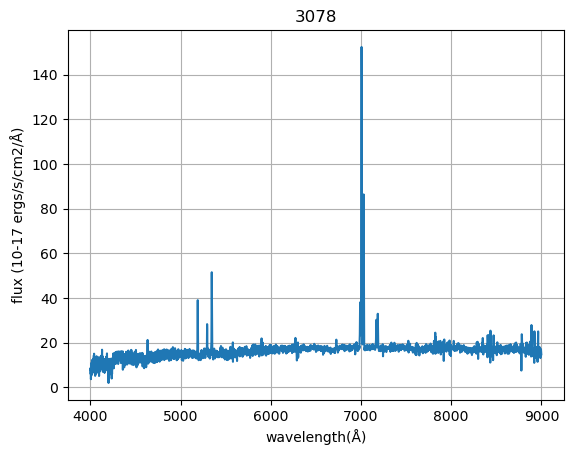

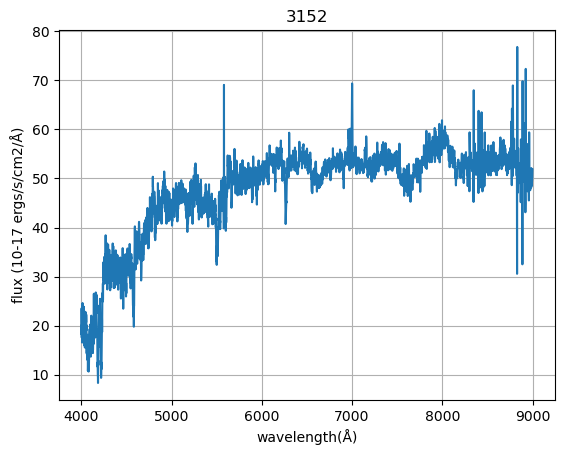

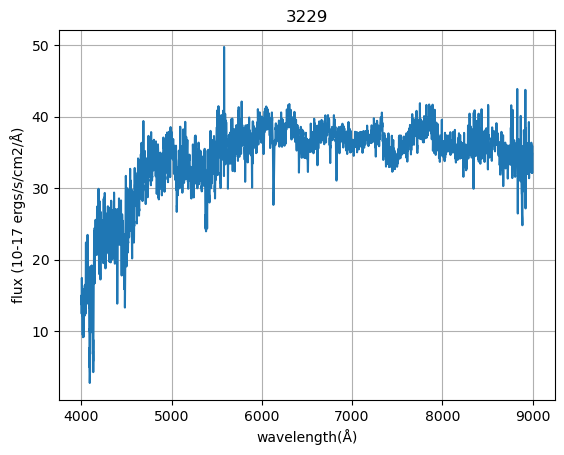

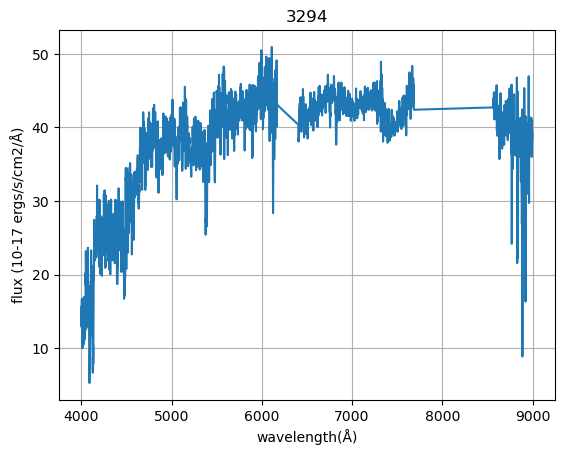

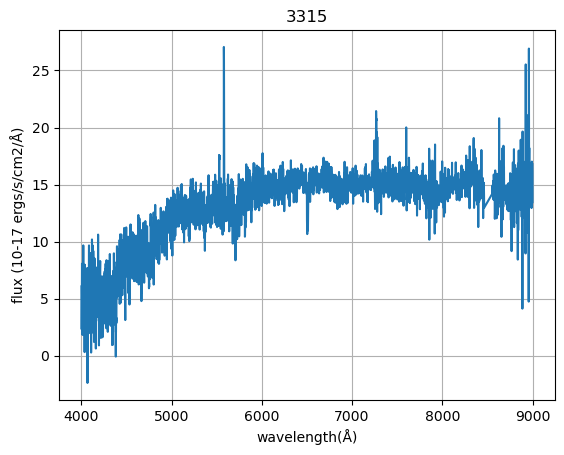

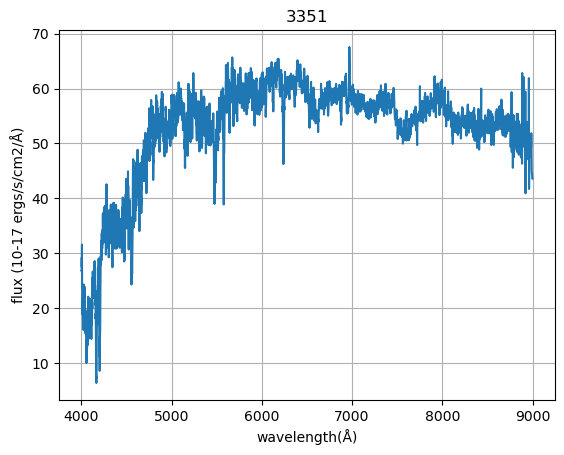

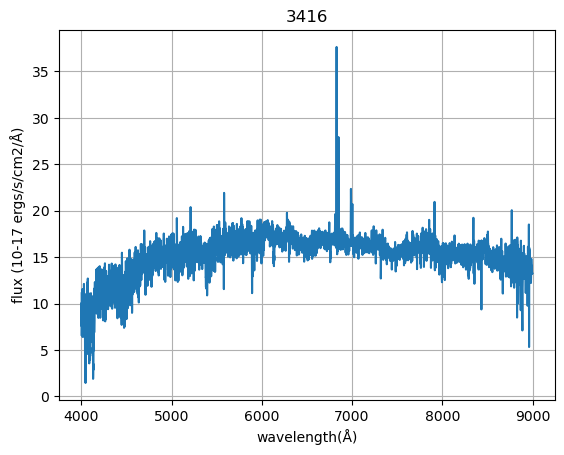

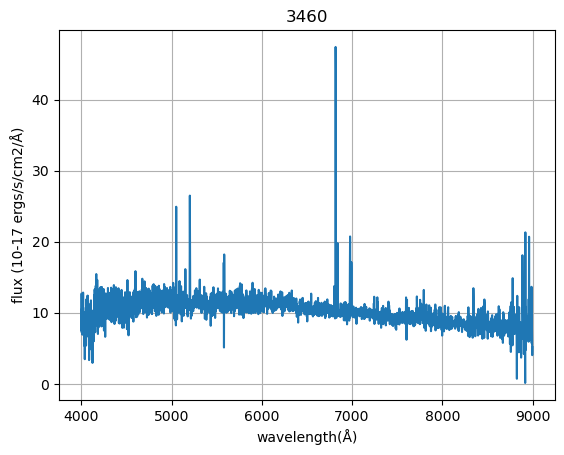

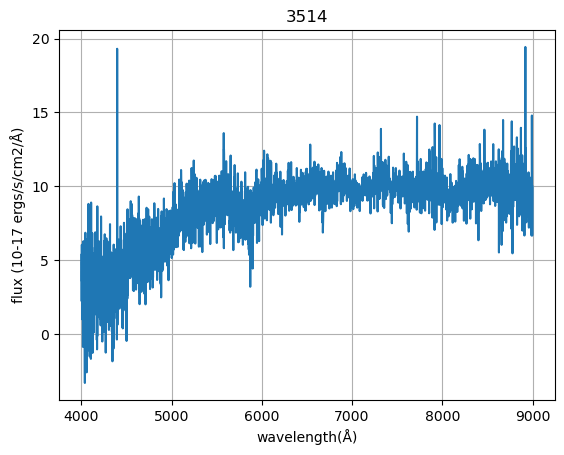

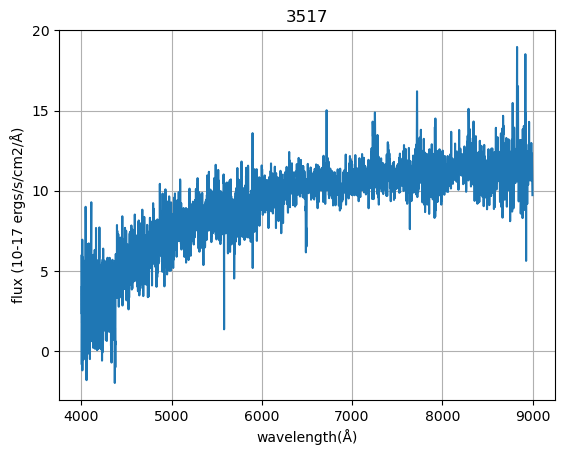

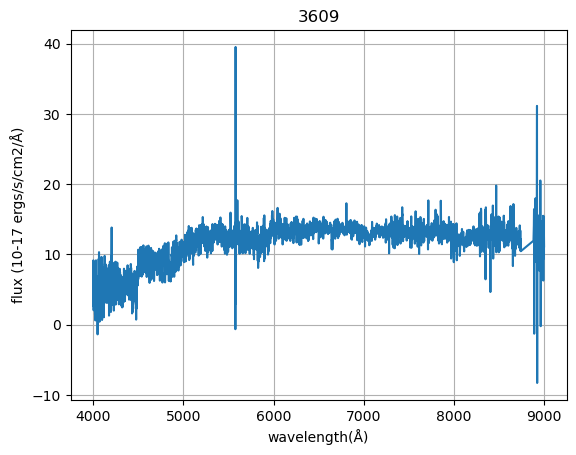

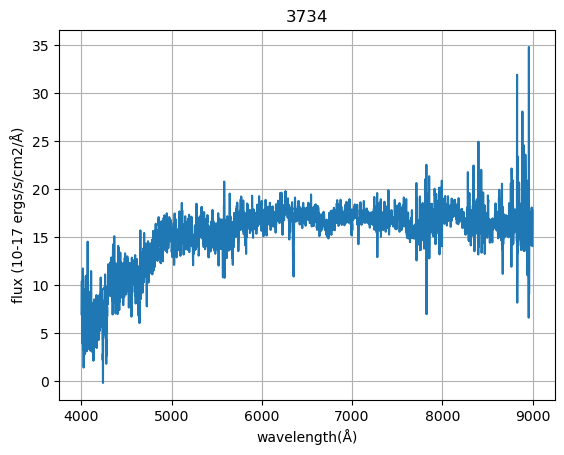

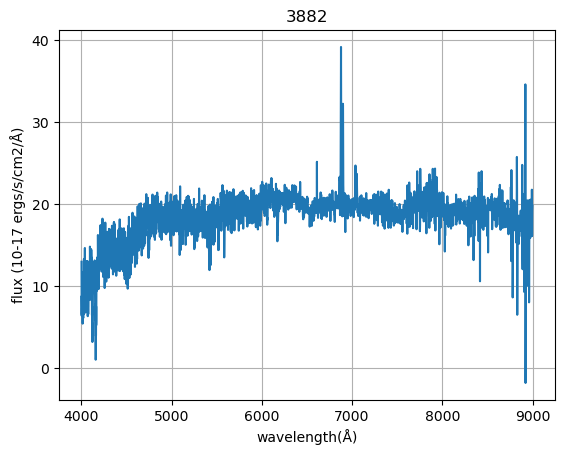

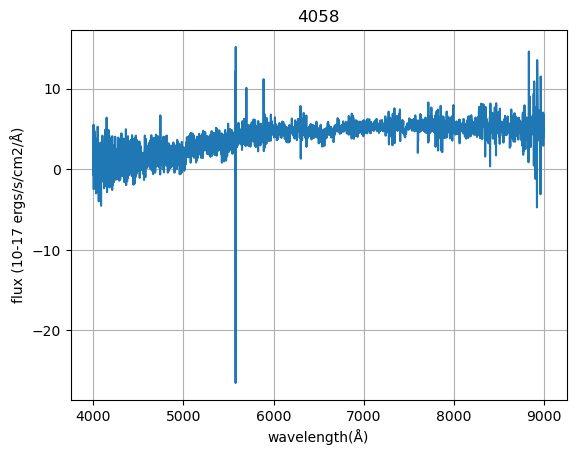

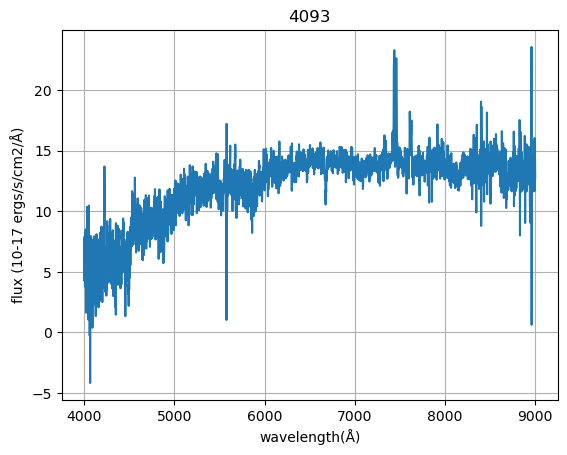

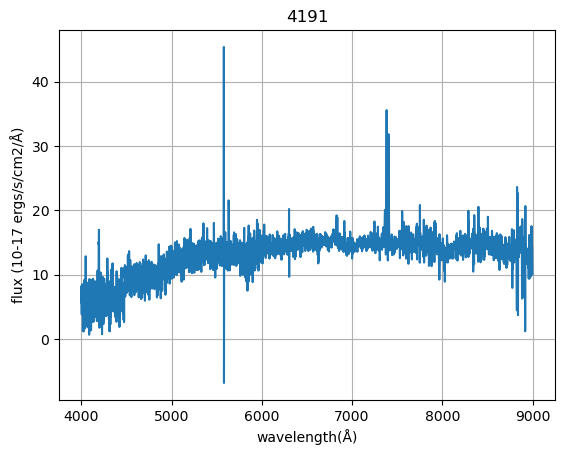

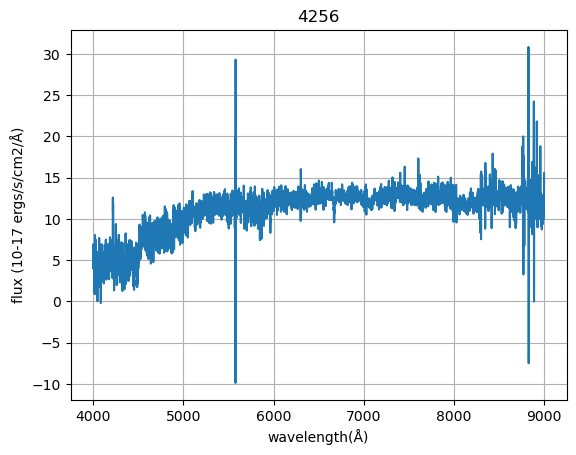

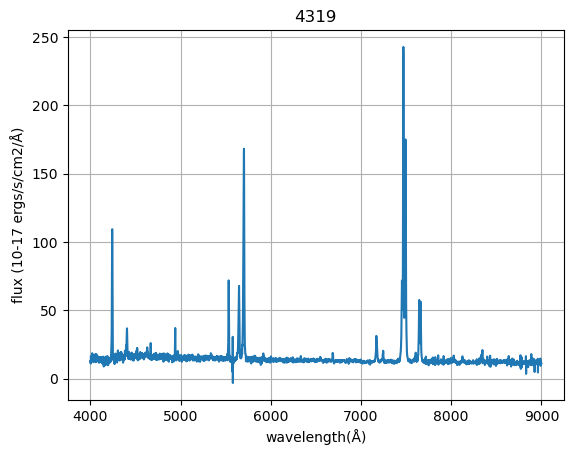

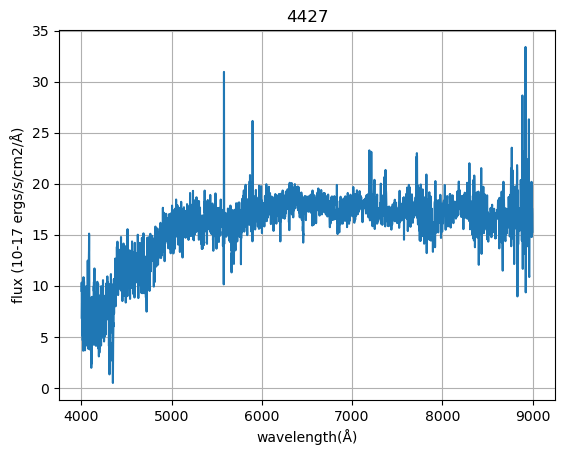

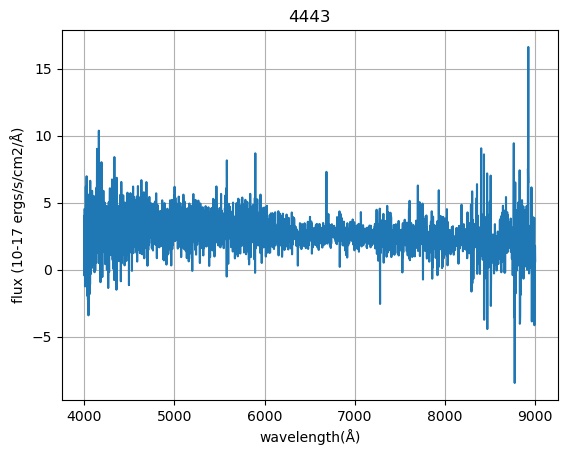

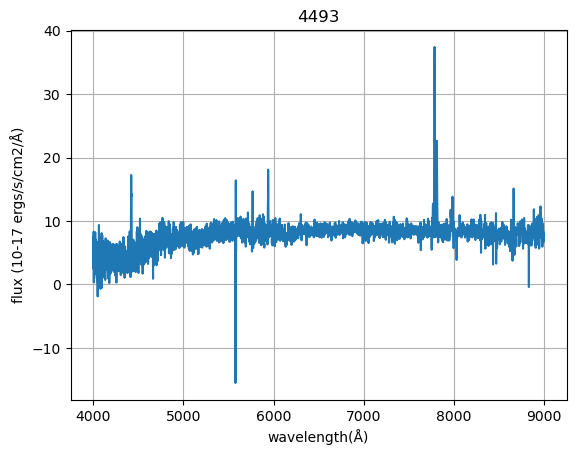

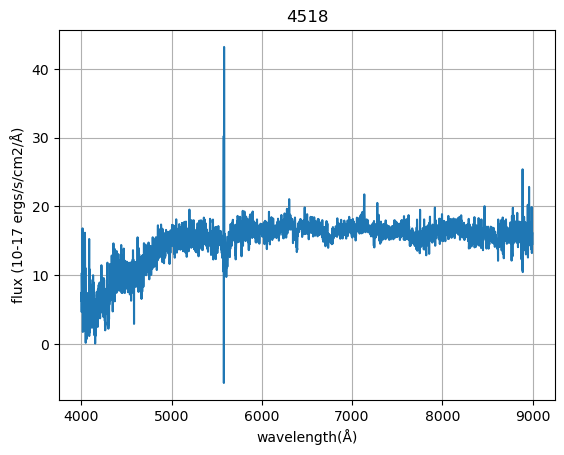

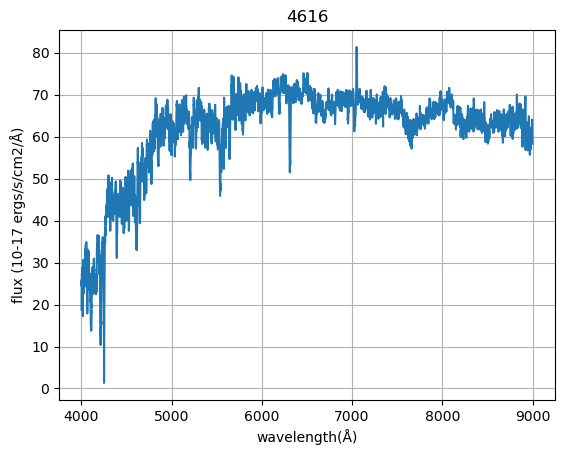

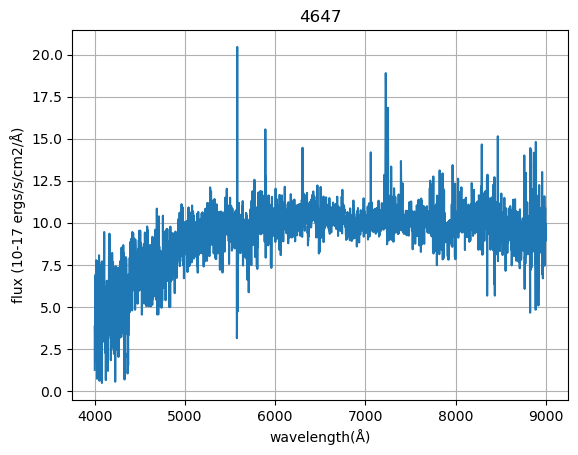

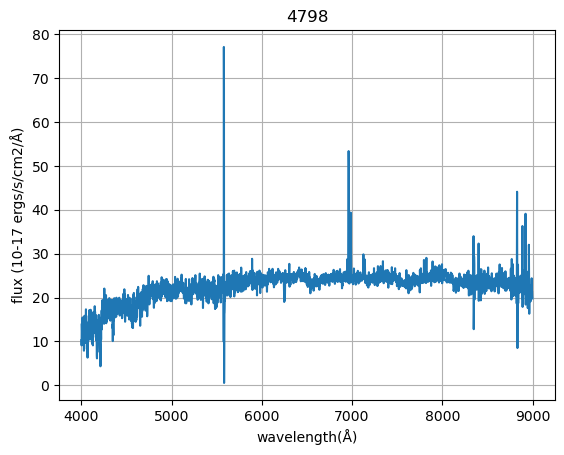

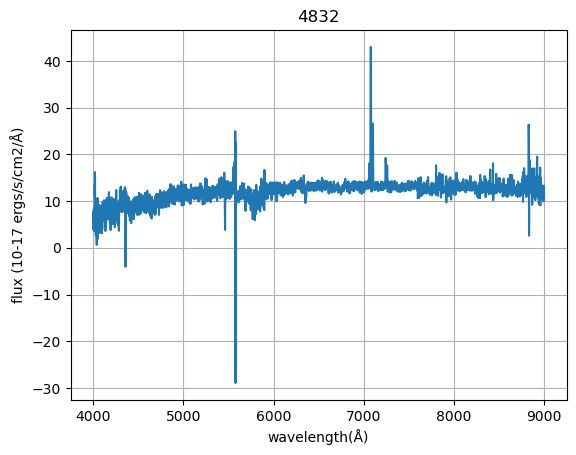

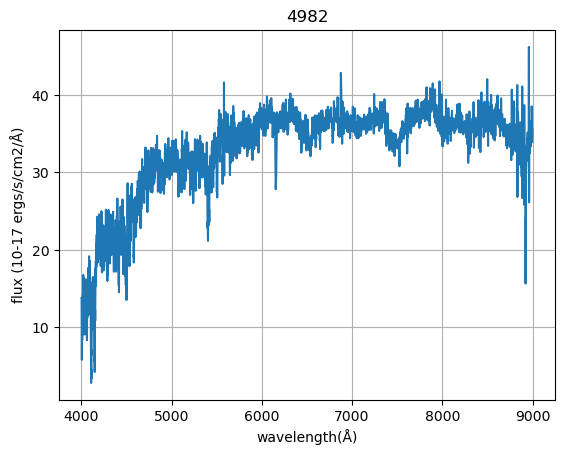

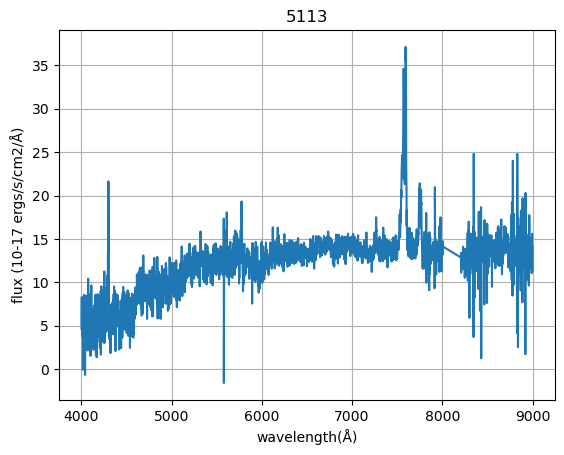

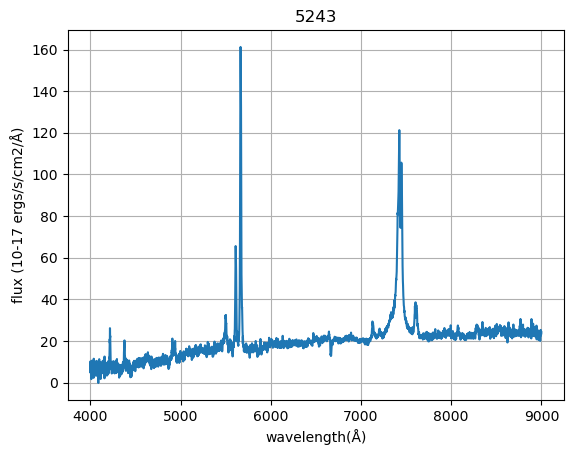

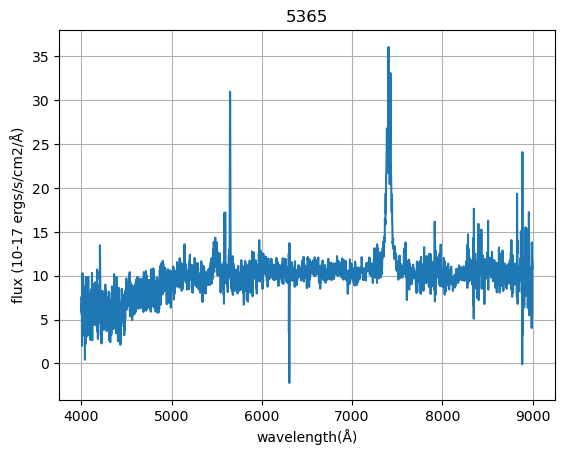

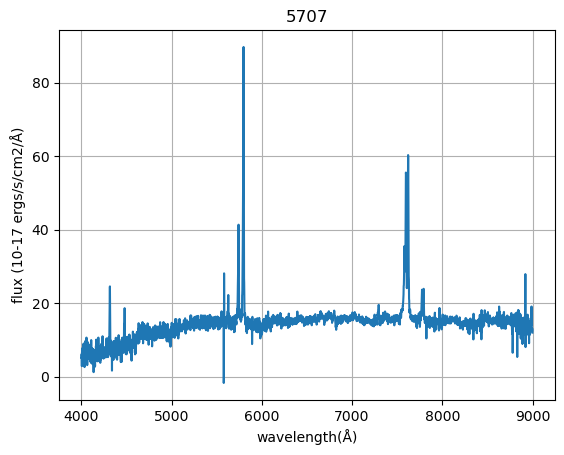

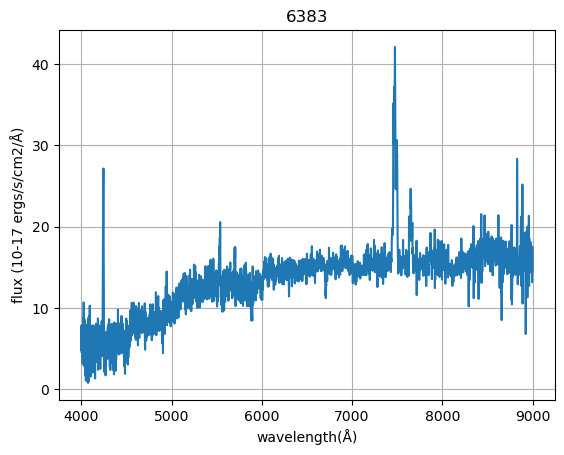

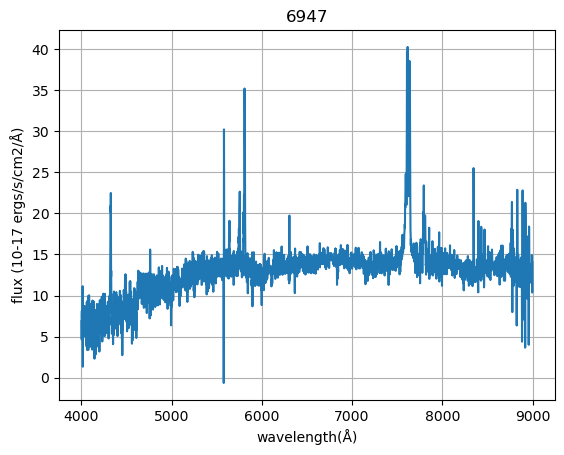

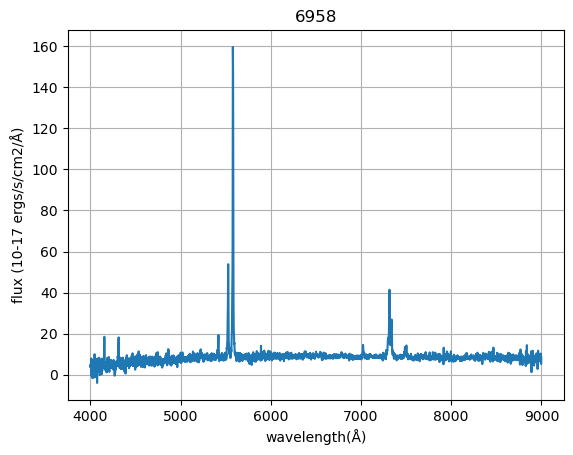

In [31]:
for i in wrong_predictions:  
    plt.plot(wavelengths, data[i]) 
    plt.xlabel('wavelength(Å)') 
    plt.ylabel('flux (10-17 ergs/s/cm2/Å)') 
    plt.grid(True)
    plt.title(str(i))
    plt.show()

## Simple benchmarking with the scikit-learn package

In [32]:
# SVM support vector machine
# see: https://scikit-learn.org/stable/modules/svm.html
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.)
clf.fit(data_training, labels_training)
clf.score(data_test, labels_test)

0.3485714285714286

In [33]:
# Random forest
# see: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier(n_estimators=100, random_state=123)
clf2.fit(data_training, labels_training)
clf2.score(data_test, labels_test)

0.7642857142857142

In [34]:
# Logistic regression
# see: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.linear_model import LogisticRegression
clf1 = LogisticRegression(max_iter=10000, random_state=123)
clf1.fit(data_training, labels_training)
clf1.score(data_test, labels_test)

0.85

In [35]:
# Gaussian naive Bayes
# see: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
from sklearn.naive_bayes import GaussianNB
clf3 = GaussianNB()
clf3.fit(data_training, labels_training)
clf3.score(data_test, labels_test)

0.5385714285714286